## import amd setup

In [1]:
import numpy as np
import pyDR as DR
from pyDR.Project import Project
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pickle
import os
from copy import deepcopy

In [2]:
#full_ile_resn = [48, 80, 123, 137, 142, 143, 162, 190, 202, 208, 213, 231, 269]
ile_resn = [3, 13, 23, 30, 36, 44, 61]
#test_list = ["test_001", "test_002", "test_003", "test_010", "test_011", "test_014", "test_015", "test_charm"]
test_list = ["test_001", "test_002", "test_015", "test_003", "test_010", "test_014", "test_011", "test_charm"]
trj_slices = [1,2,3,4]
#color_list = ["lightcoral","firebrick","maroon","darkgreen","cornflowerblue","royalblue","gold"]
color_list = ["#ff5100","#b35348","#ff00e8","#7a0091","#0059ff","#008da5","#7cfe89","#fbdc00"]

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", color_list)

In [4]:
#dir = "/home/mlehner/pyDR/1ubq_data/"
dir = "/localhome/mlehner/nmr/1ubq/"

In [5]:
data = {}
for test in test_list:
    slice_dict = {}
    for trj_slice in trj_slices:
        resn_dict = {}
        for resn in ile_resn:
            try:
                out=pickle.load(open(f"{dir}{test}/{trj_slice}_{resn}.p","rb"))
                resn_dict[resn] = out
            except:
                print(f"Failed to load {dir}{test}/{trj_slice}_{resn}.p")
        slice_dict[trj_slice] = resn_dict
    data[test] = slice_dict

In [6]:
#data["test_001"][1][13][0]["ct_finF"]

In [7]:
tf=100000
t=np.arange(tf>>1)*.005

## tot plots

In [8]:
def creat_split_plots(out, save=None, show=True):    
    titles=[['Methyl rot.',r'$\chi_2$ rot.',r'$\chi_1$ rot.',r'C$\alpha$-C$\beta$ motion','Total'],
                ['Methyl rot.',r'$\chi_2$ rot.',r'$\chi_1$ rot.',r'C$\alpha$-C$\beta$ motion','Total'],
                ['Methyl lib.','Methyl hop.',r'$\chi_2$ lib.',r'$\chi_2$ hop.',
                r'$\chi_1$ lib.',r'$\chi_1$ hop.',r'C$\alpha$-C$\beta$ motion','Total']]
    fig=plt.figure('Methyl Dynamics')
    fig.clear()
    fig.set_size_inches([10.27,  9.03])
    ax=[]
    ax.append([fig.add_subplot(5,3,k+1) for k in range(0,15,3)])
    ax.append([fig.add_subplot(5,3,k+1) for k in range(1,15,3)])
    ax.append([fig.add_subplot(5,6,k+1) for k in [4,5,10,11,16,17,22]])
    ax[-1].append(fig.add_subplot(5,3,15))

    for a0,t0 in zip(ax,titles):
        for a, title in zip(a0,t0):
            a.set_title(title)

    i = 0
    j = 0
    for inc,ax0 in zip(range(3),ax):
        i += 1 
        out_include = out[inc]       
        for ct,a in zip(out_include['ct_finF'],ax0):
            j += 1
            try:
                a.cla()
                a.plot(t,ct.mean(0)[:tf>>1])
                a.set_ylim([0,1.05])
                S2=ct.mean(0)[tf>>2:tf>>1].mean()
                b=np.argwhere(ct.mean(0)-S2<0)[0,0]
                #tc0=np.max([.001,((ct.mean(0)[:b]-S2)/(1-S2)).sum()*.005])
                tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
                fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
                S2,tc=least_squares(fun,[S2,tc0]).x
                a.plot(t,S2+(1-S2)*np.exp(-t/tc),color='grey',linestyle=':')
                a.set_xlim([0,50*tc])
                #a.set_xlim([0,np.min([10*tc, out['t'][:tf>>1]])])
                #a.set_title(f"{i}-{j}")
            except:
                pass
        ax0[-1].semilogx(out_include['t'][:tf>>1],out_include['ct'].mean(0)[:tf>>1])
        ax0[-1].semilogx(out_include['t'][:tf>>1],out_include['ct_prod'].mean(0)[:tf>>1])
        ax0[-1].set_ylim([0,.5])
    
    for a0,t0 in zip(ax,titles):
        for a, title in zip(a0,t0):
            a.set_title(title, y=1.0, pad=-14)
        
    fig.set_size_inches([180/25.4,220/25.4])

    if save:
        plt.savefig("./out_figures/ile/"+save+"/split_plot.pdf")

    if show:
        plt.show()
    else:
        plt.close()

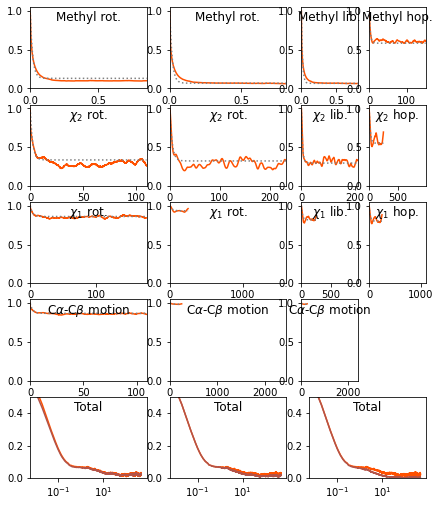

In [9]:
creat_split_plots(data["test_001"][1][13])

In [10]:
out = data["test_001"][1][13]

In [11]:
print(len(out))
print(len(out[0]["ct_finF"]))

3
4


In [12]:
def calc_S2_tc(ct, t):
    S2 = ct.mean(0)[tf>>2:tf>>1].mean()
    b=np.argwhere(ct.mean(0)-S2<0)[0,0]
    tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
    fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
    S2,tc=least_squares(fun,[S2,tc0]).x
    return S2, tc

In [13]:
np.vstack([data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["ct_finF"][1]]).shape

(12, 100001)

In [14]:
def calc_S2_tc_from_multipleCT_with_error(ct, t):
    #ct = np.vstack(ct_list)
    try:
        S2 = ct.mean(0)[tf>>2:tf>>1].mean()
        b=np.min([2*np.argwhere(ct.mean(0)-S2<0)[0,0], len(ct.mean(0))//2])
        tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
        fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
        lsq_result = least_squares(fun,[S2,tc0])
        S2,tc=lsq_result.x
        S2_err = np.sqrt(np.diag(lsq_result.jac.T @ lsq_result.jac))[0]
        tc_err = np.sqrt(np.diag(lsq_result.jac.T @ lsq_result.jac))[1]
    except Exception as e:
        print(e)
        return np.nan, np.nan, np.nan, np.nan
    return S2, tc, S2_err, tc_err

In [15]:
print(calc_S2_tc(data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][2][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][3][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][4][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))

(0.13139000311680557, 0.05345308160277393)
(0.11415843788568918, 0.057464369864622916)
(0.12235718797280044, 0.05529666840473391)
(0.12030276889091261, 0.05127378905685338)


In [16]:
stacked_test001_61 = np.vstack([data["test_001"][i][61][0]["ct_finF"][0] for i in trj_slices])

In [17]:
calc_S2_tc_from_multipleCT_with_error(stacked_test001_61, data["test_001"][1][61][0]["t"])

(0.10886526934043218,
 0.05763550546081593,
 0.0001444704830646515,
 0.00022257212549448013)

In [18]:
#data["test_001"][1]

In [19]:
data_stacked_slices = {}
for test in data:
    resn_dict = {}
    for resn in ile_resn:
        motion_dict = {"ct_finF":{}, "t":{}}
        for motion_selector in [0,1,2,3]:
            stacked_slice_temp = None
            try:
                stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices])
            except:
                try:
                    stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[:-1]])
                except:
                    try:
                        stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[1:]])
                    except:
                        print(f"Error in {test} {resn}")
            motion_dict["ct_finF"][motion_selector] = stacked_slice_temp
        motion_dict["t"] = data[test][1][resn][0]["t"]
        resn_dict[resn] = motion_dict
    data_stacked_slices[test] = resn_dict

In [20]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [21]:
data_stacked_slices["test_001"][61]["t"].shape

(100001,)

In [22]:
def create_ct_figure(ct_list, title="", legend_str=[""], showFit=True, xrange=None, yrange=None, save=None, show=True):
    fig = plt.figure()
    ax = fig.add_subplot()
    s2_list = []
    tc_list = []
    S2_err_list = []
    tc_err_list = []
    for ct in ct_list:
        ax.plot(t,ct.mean(0)[:tf>>1])
    for ct in ct_list:
        #S2, tc = calc_S2_tc(ct, t)
        S2, tc, S2_err, tc_err = calc_S2_tc_from_multipleCT_with_error(ct, t)
        if showFit:
            ax.plot(t,S2+(1-S2)*np.exp(-t/tc),color='grey',linestyle=':')
        s2_list.append(S2)
        tc_list.append(tc)
        S2_err_list.append(S2_err)
        tc_err_list.append(tc_err)
    if xrange:
        ax.set_xlim(xrange)
    else:
        ax.set_xlim([0,50*np.max(tc_list)])
    if yrange:
        ax.set_ylim(yrange)
    else:
        ax.set_ylim([0,1.05])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("S2")
    #ax.legend([f"{leg_str}, S2={s2:.2f}, tc={tc:.2f}" for s2,tc,leg_str in zip(s2_list,tc_list, legend_str)])
    legend_str = [f"{leg_str}, S2={s2:.3f}±{s2_err:.3f}, tc={tc:.3f}±{tc_err:.4f}" for s2,s2_err,tc,tc_err,leg_str in zip(s2_list,S2_err_list,tc_list,tc_err_list, legend_str)]
    ax.legend(legend_str)
    for leg_str in legend_str:
        print(leg_str)
    ax.set_title(title)
    if save:
        plt.savefig(save)
    fig.show()

ILE61, S2=0.109±0.001, tc=0.029±0.0007
ILE13, S2=0.111±0.001, tc=0.019±0.0005


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


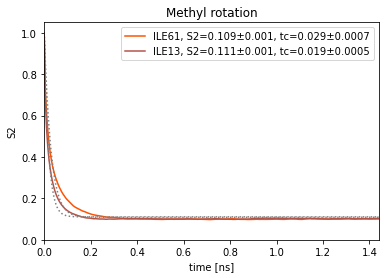

In [23]:
create_ct_figure(ct_list=[data_stacked_slices["test_001"][61]["ct_finF"][0], data_stacked_slices["test_001"][13]["ct_finF"][0]], title="Methyl rotation", legend_str=["ILE61", "ILE13"], showFit=True, xrange=None, yrange=None, save=None, show=True)

test_001, S2=0.109±0.001, tc=0.029±0.0007
test_002, S2=0.102±0.003, tc=0.006±0.0029
test_015, S2=0.110±0.000, tc=0.029±0.0006
test_003, S2=0.103±0.003, tc=0.007±0.0050
test_010, S2=0.111±0.000, tc=0.032±0.0004
test_014, S2=0.104±0.004, tc=0.007±0.0054
test_011, S2=0.111±0.000, tc=0.030±0.0004
test_charm, S2=0.109±0.000, tc=0.039±0.0004


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


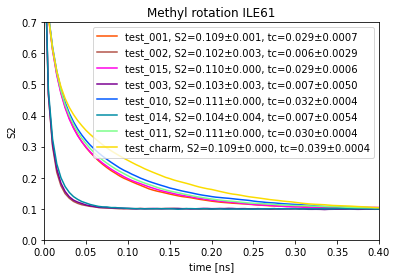

In [24]:
out_data = [data_stacked_slices[test][61]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE61.svg")

test_001, S2=0.689±0.077, tc=0.368±0.0660
test_002, S2=0.726±0.054, tc=0.375±0.0289
test_015, S2=0.729±0.032, tc=0.307±0.0769
test_003, S2=0.689±0.055, tc=0.344±0.1049
test_010, S2=0.622±0.056, tc=0.503±0.0688
test_014, S2=0.606±0.071, tc=0.524±0.0568
test_011, S2=0.681±0.034, tc=0.333±0.0841
test_charm, S2=0.644±0.237, tc=0.127±0.1956


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


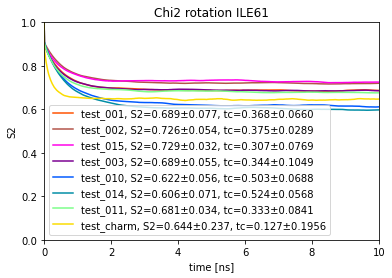

In [25]:
out_data = [data_stacked_slices[test][61]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE61.svg")

test_001, S2=0.984±0.010, tc=0.005±0.0061
test_002, S2=0.986±0.003, tc=0.005±0.0025
test_015, S2=0.985±0.006, tc=0.005±0.0053
test_003, S2=0.984±0.007, tc=0.005±0.0078
test_010, S2=0.980±0.019, tc=0.007±0.0127
test_014, S2=0.978±0.015, tc=0.006±0.0178
test_011, S2=0.984±0.004, tc=0.006±0.0072
test_charm, S2=0.980±0.006, tc=0.008±0.0080


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


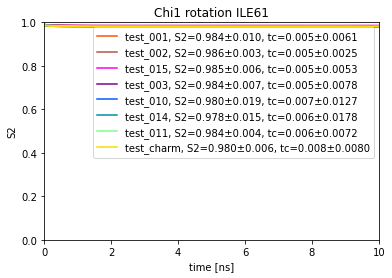

In [26]:
out_data = [data_stacked_slices[test][61]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE61.svg")

test_001, S2=0.111±0.001, tc=0.019±0.0005
test_002, S2=0.103±0.048, tc=0.005±0.0734
test_015, S2=0.107±0.000, tc=0.019±0.0011
test_003, S2=0.103±0.045, tc=0.005±0.0734
test_010, S2=0.109±0.001, tc=0.019±0.0010
test_014, S2=0.103±0.030, tc=0.005±0.0323
test_011, S2=0.108±0.001, tc=0.020±0.0005
test_charm, S2=0.104±0.000, tc=0.029±0.0006


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


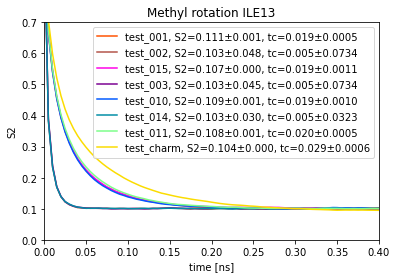

In [27]:
out_data = [data_stacked_slices[test][13]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE13.svg")

test_001, S2=0.358±3.911, tc=2.590±2.5925
test_002, S2=0.434±0.961, tc=3.237±0.7383
test_015, S2=0.315±1.835, tc=4.158±1.0503
test_003, S2=0.348±2.547, tc=2.201±1.6871
test_010, S2=0.328±0.838, tc=2.532±0.9937
test_014, S2=0.357±6.842, tc=3.359±4.8761
test_011, S2=0.455±4.451, tc=2.077±2.9137
test_charm, S2=0.456±5.557, tc=0.505±2.6991


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


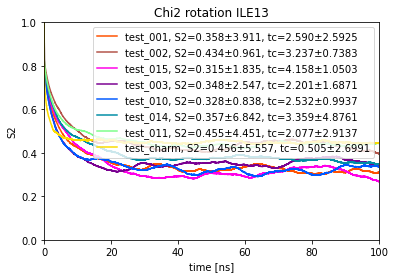

In [28]:
out_data = [data_stacked_slices[test][13]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE13.svg")

test_001, S2=0.866±0.141, tc=4.363±0.1307
test_002, S2=0.888±0.024, tc=5.500±0.0181
test_015, S2=0.862±0.163, tc=7.853±0.1534
test_003, S2=0.870±0.037, tc=3.412±0.0626
test_010, S2=0.864±0.019, tc=4.205±0.0443
test_014, S2=0.869±0.032, tc=6.111±0.1577
test_011, S2=0.894±0.239, tc=3.468±0.1546
test_charm, S2=0.927±0.044, tc=0.701±0.0599


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


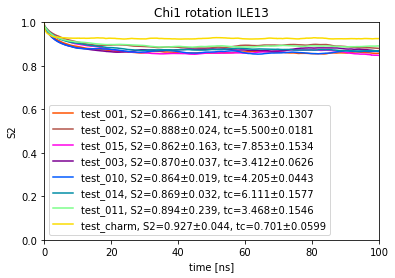

In [29]:
out_data = [data_stacked_slices[test][13]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE13.svg")

In [30]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [31]:
data_S2_tc = {}
for test in test_list:
    test_dict = {}
    for resn in ile_resn:
        resn_dict = {}
        for motion in [0,1,2,3]:
            S2, tc, S2_err, tc_err = calc_S2_tc_from_multipleCT_with_error(data_stacked_slices[test][resn]["ct_finF"][motion], t)
            resn_dict[motion] = {"S2":S2, "tc":tc, "S2_err":S2_err, "tc_err":tc_err}
        test_dict[resn] = resn_dict
    data_S2_tc[test] = test_dict

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys


operands could not be broadcast together with shapes (50000,) (74914,) 
operands could not be broadcast together with shapes (50000,) (75378,) 
operands could not be broadcast together with shapes (50000,) (60616,) 
operands could not be broadcast together with shapes (50000,) (51244,) 
operands could not be broadcast together with shapes (50000,) (67112,) 
operands could not be broadcast together with shapes (50000,) (64990,) 


Text(0.5, 1.0, 'Methyl rotation ILE61')

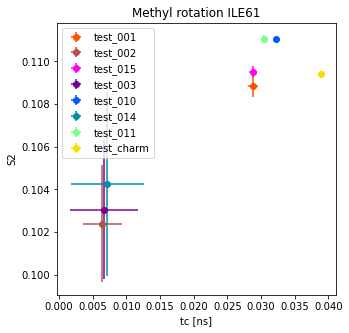

In [32]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][0]["tc"], data_S2_tc[test][61][0]["S2"], xerr=data_S2_tc[test][61][0]["tc_err"], yerr=data_S2_tc[test][61][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE61")

Text(0.5, 1.0, 'Chi2 rotation ILE61')

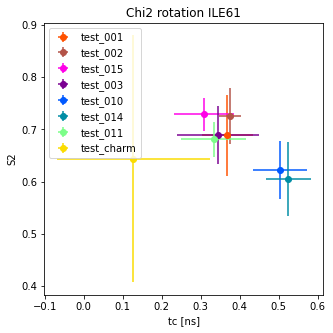

In [33]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][1]["tc"], data_S2_tc[test][61][1]["S2"], xerr=data_S2_tc[test][61][1]["tc_err"], yerr=data_S2_tc[test][61][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE61")

Text(0.5, 1.0, 'Chi1 rotation ILE61')

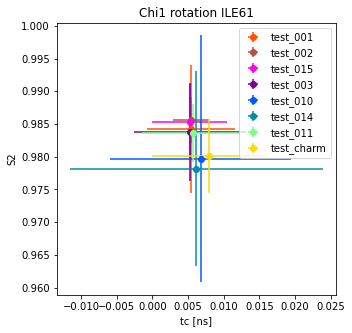

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][2]["tc"], data_S2_tc[test][61][2]["S2"], xerr=data_S2_tc[test][61][2]["tc_err"], yerr=data_S2_tc[test][61][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE61")

Text(0.5, 1.0, 'Methyl rotation ILE13')

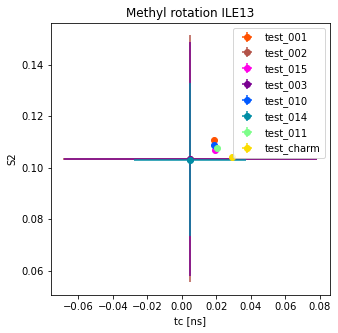

In [35]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][0]["tc"], data_S2_tc[test][13][0]["S2"], xerr=data_S2_tc[test][13][0]["tc_err"], yerr=data_S2_tc[test][13][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE13")

Text(0.5, 1.0, 'Chi2 rotation ILE13')

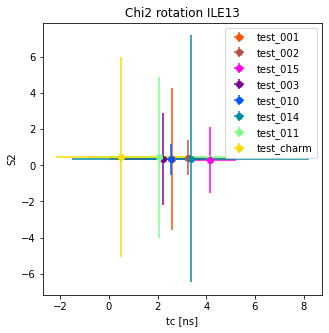

In [36]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][1]["tc"], data_S2_tc[test][13][1]["S2"], xerr=data_S2_tc[test][13][1]["tc_err"], yerr=data_S2_tc[test][13][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE13")

Text(0.5, 1.0, 'Chi1 rotation ILE13')

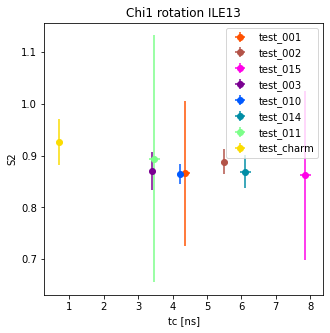

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][2]["tc"], data_S2_tc[test][13][2]["S2"], xerr=data_S2_tc[test][13][2]["tc_err"], yerr=data_S2_tc[test][13][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE13")

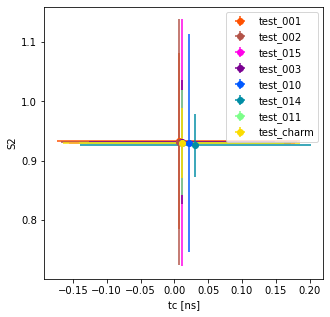

In [46]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][3]["tc"], data_S2_tc[test][61][3]["S2"], xerr=data_S2_tc[test][61][3]["tc_err"], yerr=data_S2_tc[test][61][3]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()

In [45]:
for motion in [0,1,2,3]:
    print(data_S2_tc[test_list[0]][13][motion]["S2"])

0.11077787019668245
0.35828386894359654
0.8657863987040538
0.8661578303016326


In [38]:
# save data_S2_tc as numpy array
np.save("./1ubq_data/1ubq_data_S2_tc.npy", data_S2_tc)

In [39]:
data_S2_tc2 = np.load("./1ubq_data/1ubq_data_S2_tc.npy", allow_pickle=True).item()

In [40]:
data_S2_tc2

{'test_001': {3: {0: {'S2': 0.11056271371281175,
    'tc': 0.03613432596047006,
    'S2_err': 0.00043854862451553345,
    'tc_err': 0.0005948469042778015},
   1: {'S2': 0.6555874074630643,
    'tc': 47.65382516814113,
    'S2_err': 1.604018211364746,
    'tc_err': 0.7119459433145667},
   2: {'S2': 0.9313914077628171,
    'tc': 75.08516878712493,
    'S2_err': 0.017712295055389404,
    'tc_err': 0.026572188223629004},
   3: {'S2': 0.9446498921466844,
    'tc': 0.13524239673572333,
    'S2_err': 0.0634119063615799,
    'tc_err': 0.06453046202659607}},
  13: {0: {'S2': 0.11077787019668245,
    'tc': 0.018845563763793687,
    'S2_err': 0.0006154184229671955,
    'tc_err': 0.0004972917959094048},
   1: {'S2': 0.35828386894359654,
    'tc': 2.5899720662136962,
    'S2_err': 3.9110649824142456,
    'tc_err': 2.592513516074246},
   2: {'S2': 0.8657863987040538,
    'tc': 4.3627959181576355,
    'S2_err': 0.14072178304195404,
    'tc_err': 0.1307467242313534},
   3: {'S2': 0.8661578303016326,
 